In [1]:
import json
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import networkx
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
from networkx.algorithms.components.connected import connected_components

In [2]:
WIKI_FIELDS = ['gender', 'birth', 'occupation_ids', 'citizenship_id']

def convert_item(item):
    new_item = {}
    new_item['quotation'] = item['q']
    new_item['date'] = item['d']
    new_item['speaker'] = item['s']
    new_item['numOccurrences'] = item['o']
    
    for field in WIKI_FIELDS:
        new_item[field] = item[field]
        new_item[field] = item[field]
        new_item[field] = item[field]
        new_item[field] = item[field]
    return new_item

def select_by_index(item, index):
    item = item.copy()
    
    for field in WIKI_FIELDS:
        item[field] = item[field][index]
    return item

In [3]:
data = []
topic = 'climate change'

# TODO: REMOVE TOPIC (CHANGE RAW DATA)
for line in open('data/union.json'):
    parsed = json.loads(line)
    if topic in parsed['q']:
        data.append(json.loads(line))

data = [convert_item(item) for item in data]
        
with open('data/countries_vocab.json') as f:
    text = f.read()
    
countries = json.loads(text.replace('}{', ','))

with open('data/occupations_vocab.json') as f:
    text = f.read()
    
occupations_dict = json.loads(text.replace('}{', ','))

# Explore the data

In [4]:
data[0]

{'quotation': 'the report of the ipcc has once again made it crystal clear climate change is manmade and is accelerating the impact will be dramatic unless we take resolute action',
 'date': '2008-10-06 17:57:30',
 'speaker': 'angela merkel',
 'numOccurrences': 1,
 'gender': ['female'],
 'birth': ['+1954-07-17T00:00:00Z'],
 'occupation_ids': [['Q82955', 'Q169470', 'Q48352']],
 'citizenship_id': ['Q183']}

In [5]:
# 1. Удаляем объекты, где отсуствуют элементы в массивах (e.g. gender = [])
# 2. Разделяем на 2 массива: первый, где один объект в массиве gender, второй, где несколько

In [6]:
data_single_item = []
data_multiple_items = []
for item in data:
    if len(item['gender']) > 1:
        data_multiple_items.append(item)
    elif len(item['gender']) == 1:
        if all(item[field][0] is not None for field in WIKI_FIELDS):
            item = select_by_index(item, 0)
            data_single_item.append(item)

In [7]:
data_multiple_items[0]

{'quotation': 'if we dont do that we will in effect just export emissions export our industries export the problem and we will have no discernible effect on climate change around the world',
 'date': '2008-09-30 08:12:24',
 'speaker': 'andrew robb',
 'numOccurrences': 1,
 'gender': ['male', 'male'],
 'birth': [None, '+1951-08-20T00:00:00Z'],
 'occupation_ids': [['Q33999'], ['Q82955']],
 'citizenship_id': [None, 'Q408']}

In [8]:
len(data_multiple_items), len(data_single_item)

(20221, 47530)

In [9]:
name2occur = defaultdict(int)
for item in data_multiple_items:
    name2occur[item['speaker'].lower()] += 1

In [10]:
sorted(name2occur.items(), key=lambda x: x[1], reverse=True)[:10]

[('john kerry', 456),
 ('jerry brown', 363),
 ('michael mann', 341),
 ('gordon brown', 253),
 ('donald trump', 211),
 ('manmohan singh', 198),
 ('james hansen', 147),
 ('stephen harper', 143),
 ('tony abbott', 133),
 ('nicholas stern', 132)]

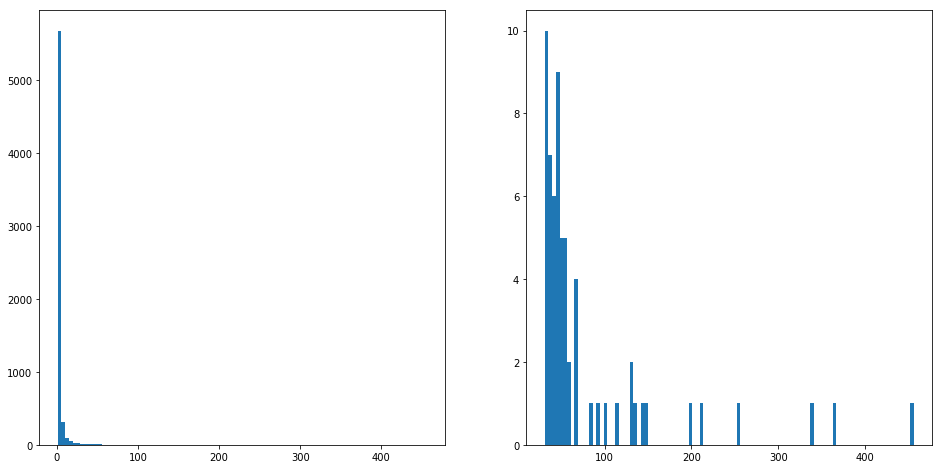

In [11]:
# Distribution of num of quotes

vals = np.array(list(name2occur.values()))

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.hist(vals, bins=100)

plt.subplot(122)
plt.hist(vals[vals > 30], bins=100)
plt.show()

In [12]:
data_multiple_items_new = []


for item in data_multiple_items:
    not_none_ids = []
    for index in range(len(item[WIKI_FIELDS[0]])):
        if all(item[field][index] is not None for field in WIKI_FIELDS):
            not_none_ids.append(index)
    
    if len(not_none_ids) == 1:
        item = select_by_index(item, not_none_ids[0])
        data_single_item.append(item)
    else:
        data_multiple_items_new.append(item)

data_multiple_items = data_multiple_items_new

In [13]:
len(data_multiple_items), len(data_single_item)

(15614, 52137)

In [14]:
name2occur = defaultdict(int)
for item in data_multiple_items:
    name2occur[item['speaker'].lower()] += 1

In [15]:
sorted(name2occur.items(), key=lambda x: x[1], reverse=True)

[('jerry brown', 363),
 ('michael mann', 341),
 ('gordon brown', 253),
 ('donald trump', 211),
 ('james hansen', 147),
 ('tony abbott', 133),
 ('nicholas stern', 132),
 ('james shaw', 129),
 ('lisa jackson', 115),
 ('david cameron', 100),
 ('scott morrison', 91),
 ('mary robinson', 85),
 ('jim prentice', 68),
 ('elizabeth may', 67),
 ('tim flannery', 66),
 ('caroline lucas', 66),
 ('xie zhenhua', 57),
 ('larry fink', 57),
 ('john connor', 55),
 ('bob brown', 54),
 ('peter gleick', 53),
 ('bob inglis', 53),
 ('harry reid', 51),
 ('chris field', 50),
 ('harjeet singh', 49),
 ('president bush', 48),
 ('desmond tutu', 47),
 ('glen murray', 46),
 ('terry hughes', 45),
 ('roger johnson', 45),
 ('richard black', 44),
 ("martin o'malley", 44),
 ('erik solheim', 44),
 ('carlos curbelo', 44),
 ('helen clark', 43),
 ('david miller', 42),
 ('gregor robertson', 42),
 ('phil jones', 41),
 ('harsh vardhan', 41),
 ('ben rhodes', 40),
 ('charlie baker', 39),
 ('nick smith', 38),
 ('richard dixon', 38),

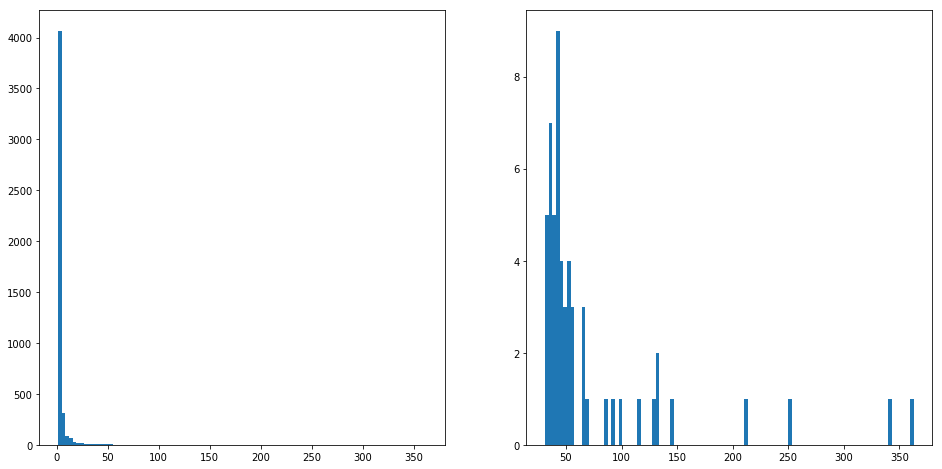

In [16]:
# Distribution of num of quotes

vals = np.array(list(name2occur.values()))

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.hist(vals, bins=100)

plt.subplot(122)
plt.hist(vals[vals > 30], bins=100)
plt.show()

In [17]:
for item in data_multiple_items:
    occ_lengths = [len(occ) if occ is not None else 0 for occ in item['occupation_ids']]
    idx = np.argmax(occ_lengths)
    
    item = select_by_index(item, idx)
    data_single_item.append(item)

In [18]:
with open('data/union_processed.json', 'w') as f:
    f.write(json.dumps(data_single_item))

# Occupations

In [19]:
def parse(path):
    with open(path, 'r') as f:
        a = f.read()
    q_list = a.split('\n')
    q = []
    for i in range(len(q_list)-1):
        q.append(json.loads(q_list[i]))
    return q

In [20]:
data = data_single_item.copy()

In [21]:
trend = topic

In [22]:
occupations = []
nones = []
for quat in data:
    try:
        occupations.extend(quat['occupation_ids'])
    except Exception:
        nones.append(quat['speaker'])

In [23]:
occupations_dist = [occupations_dict[i] for i in occupations]
c = Counter(occupations_dist)   
c = sorted(dict(c).items(), key = lambda x: x[1]) 

In [24]:
occupations_dist

['politician',
 'physicist',
 'head of state',
 'politician',
 'university teacher',
 'political scientist',
 'politician',
 'motivational speaker',
 'autobiographer',
 'painter',
 'rugby union player',
 'military officer',
 'politician',
 'politician',
 'lawyer',
 'political writer',
 'community organizer',
 'statesperson',
 'jurist',
 'politician',
 'politician',
 'lawyer',
 'political writer',
 'community organizer',
 'statesperson',
 'jurist',
 'politician',
 'financier',
 'businessperson',
 'journalist',
 'climate activist',
 'environmentalist',
 'politician',
 'diplomat',
 'politician',
 'academic',
 'researcher',
 'politician',
 'racing automobile driver',
 'historian',
 'university teacher',
 'politician',
 'political adviser',
 'barrister',
 'politician',
 'physicist',
 'spokesperson',
 'official',
 'manager',
 'conservationist',
 'politician',
 'diplomat',
 'politician',
 'banker',
 'politician',
 'economist',
 'investment banker',
 'economist',
 'politician',
 'službenik',
 

In [25]:
len(c)

1336

#### Now let's figure out the most common occupations:

In [26]:
c[::-1][:15]

[('politician', 35369),
 ('lawyer', 11151),
 ('writer', 7867),
 ('journalist', 5718),
 ('diplomat', 5619),
 ('university teacher', 5315),
 ('economist', 3924),
 ('actor', 3524),
 ('businessperson', 3254),
 ('statesperson', 3241),
 ('jurist', 3215),
 ('community organizer', 2952),
 ('environmentalist', 2947),
 ('political writer', 2858),
 ('entrepreneur', 2288)]

Occupations are simalar sometimes. For example: **artist** and **sound artist**, so we make some clusters for occupations. 

In [27]:
threshold = 90
clusters = {}
occ_set = [i[0] for i in c]
length = len(occ_set)
dist = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        dist[i, j] = fuzz.partial_ratio(occ_set[i], occ_set[j]) > threshold

In [28]:
G = networkx.convert_matrix.from_numpy_matrix(dist)

cliques = list(networkx.find_cliques(G))
cliques_text = list(list(map(lambda x: occ_set[x], c)) for c in cliques)

### Let's draw the graph for occupation, to visualised the existence of edge between diffrent occupations

In [29]:
labeldict = dict(zip(np.arange(length), occ_set))

cliques_nodes = []
for i in cliques:
    if len(i) > 3:
        cliques_nodes.extend(i)
cliques_nodes = list(set(cliques_nodes))
cliques_nodes_names = [labeldict[i] for i in cliques_nodes]

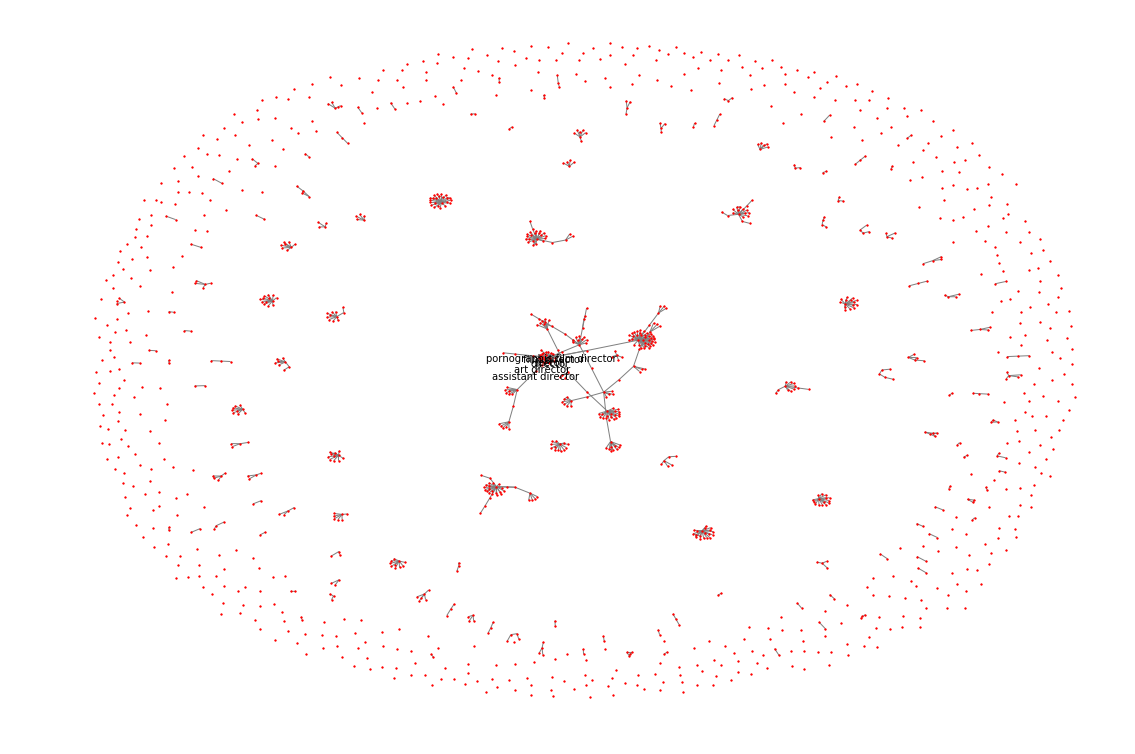

In [30]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
labels = labeldict
networkx.draw(G, node_size=3,labels = dict(zip(cliques_nodes, cliques_nodes_names)),
              font_size=10, edge_color = 'grey', font_color='black', 
              verticalalignment='top', style="solid")

In [31]:
for l in cliques_text:
    if len(l) > 3:
        print(l)

['pornographic film director', 'director', 'film director', 'rector']
['rector', 'director', 'art director', 'assistant director']


### Creating clusters for occupations:

In [32]:
# https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def make_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

In [33]:
G = make_graph(cliques)
similar_occupasions = list(connected_components(G))
clusters_occ_dict = {i: list(map(lambda x: labeldict[x], c)) for i,c in enumerate(similar_occupasions)}

In [34]:
# разделила на кластеры и беру для каждого кластера 
# название профессии как самое короткое из названий профессий, входящих в кластер

In [35]:
clusters_occ_dict_one = {}
for i, c in enumerate(similar_occupasions):
    occupation_list = sorted(list(map(lambda x: labeldict[x], c)), key = lambda x: len(x))
    clusters_occ_dict_one[i] = occupation_list[0]

In [36]:
#example:
clusters_occ_dict[55], clusters_occ_dict_one[55]

(['myrmecologist', 'gynaecologist', 'ecologist', 'marine ecologist'],
 'ecologist')

In [37]:
def define_cluster(occupation):
    for i, group_occupations in clusters_occ_dict.items():
        if occupation in group_occupations:
            return i

In [38]:
clusters_counter = [define_cluster(i) for i in occ_set]

In [39]:
clusters_counter = [define_cluster(i) for i in occ_set]
occupations_count_clusters = {clusters_occ_dict_one[i]: num for i, num in Counter(clusters_counter).items()}
data_occ = pd.DataFrame(occupations_count_clusters.values(), index=occupations_count_clusters.keys(), 
             columns = ['frequency'])

In [40]:
data_occ.sort_values(by = ['frequency'], inplace = True)
data_occ = data_occ.iloc[::-1]

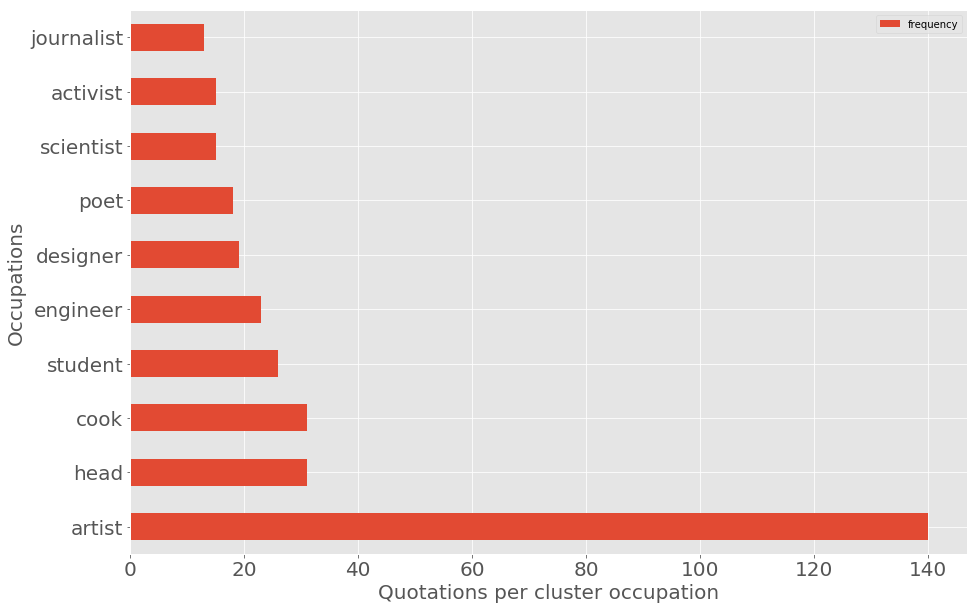

In [63]:
ax = data_occ.iloc[:10].plot.barh(figsize=(15,10), fontsize=20)
ax.set_xlabel('Quotations per cluster occupation', fontsize=20)
ax.set_ylabel('Occupations', fontsize=20)
plt.show()

# Countries

In [64]:
country2occur = defaultdict(int)
for item in data:
    country_id = item['citizenship_id']
    if country_id is not None:
        country2occur[countries[country_id]] += 1

In [65]:
countries_frec = pd.DataFrame(dict(country2occur).items(), columns=['country', 'frequency'])
countries_frec = countries_frec.set_index('country')
countries_frec.sort_values(by=['frequency'], ascending=False, inplace=True)

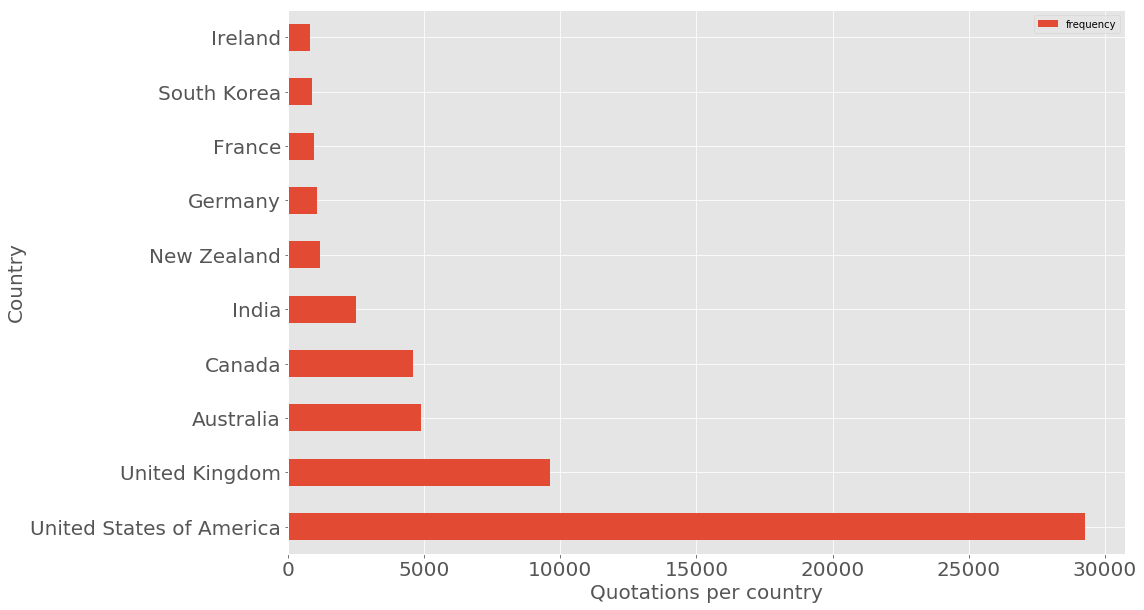

In [67]:
ax = countries_frec.iloc[:10].plot.barh(figsize=(15,10), fontsize=20)
ax.set_xlabel('Quotations per country', fontsize=20)
ax.set_ylabel('Country', fontsize=20)
plt.show()